In [62]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.stats import gaussian_kde
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
import seaborn as sns
import pandas as pd
from matplotlib.patches import Patch


In [24]:
data = open('Processed_Data.csv').read().strip().split('\n')[1:]
activity = [d.split(',')[4] for d in data]
model = [d.split(',')[-1] for d in data]

In [25]:
models = ['p5','a5','p10','a10','vp','va']
mdict = {}
for mdl in models:
    mdict[mdl] = np.array([float(activity[i]) for i in range(len(model)) if model[i]==mdl])

In [26]:
thresh = np.linspace(0,1.7,100000)
lines = []
for mdl in models:
    above = [int(sum(mdict[mdl]>t)) for t in thresh]
    lines.append(above)

Text(0.5, 0, 'Flourescence relative to CreiLOV')

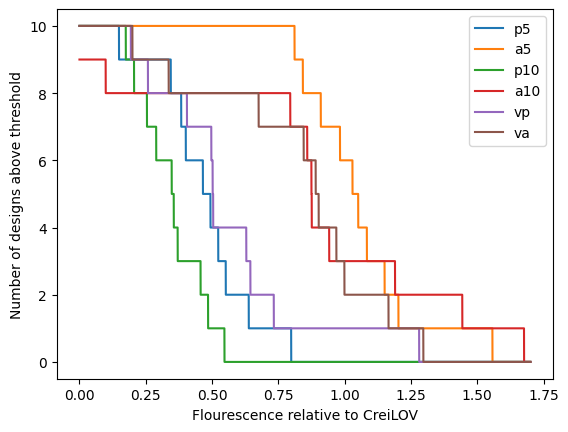

In [27]:
plt.plot(thresh,np.array(lines).T);
plt.legend(models)
plt.ylabel('Number of designs above threshold')
plt.xlabel('Flourescence relative to CreiLOV')

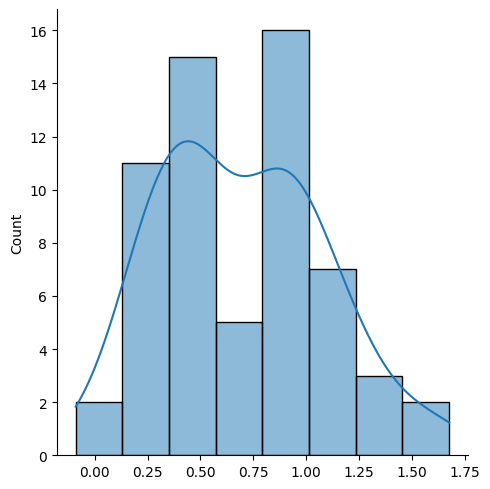

In [28]:
sns.displot([float(a) for a in activity],kde=True,bins=8)

# Estimate threshhold with KDE

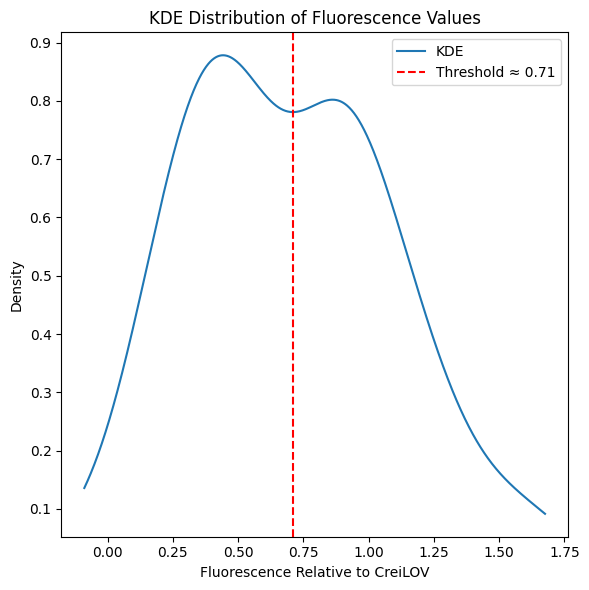

In [50]:
# estimate threshold with KDE 
data = np.array([float(a) for a in activity])

# Fit KDE
kde = gaussian_kde(data)
x = np.linspace(min(data), max(data), 1000)
kde_values = kde(x)

# Find peaks
peaks, _ = find_peaks(kde_values)

# Find valleys (inverted peaks)
valleys, _ = find_peaks(-kde_values)

# Find the valley between the two highest peaks
peak_positions = x[peaks]
valley_positions = x[valleys]

# Sort peaks by height
sorted_peak_indices = np.argsort(kde_values[peaks])[::-1]
top_two_peaks = np.sort(peak_positions[sorted_peak_indices[:2]])

# Find valley between them
threshold_candidates = valley_positions[(valley_positions > top_two_peaks[0]) & (valley_positions < top_two_peaks[1])]
threshold = threshold_candidates[np.argmin(kde(threshold_candidates))]  # pick the lowest point

# Plot
plt.figure(figsize=(6, 6))
plt.plot(x, kde_values, label='KDE')
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold ≈ {threshold:.2f}')
plt.xlabel('Fluorescence Relative to CreiLOV')
plt.ylabel('Density')
plt.title('KDE Distribution of Fluorescence Values')
plt.legend()
plt.tight_layout()
plt.savefig('./kde_plot_of_experimental_data.png', dpi=300)
plt.savefig('./kde_plot_of_experimental_data.svg')
plt.show()

In [51]:
for mdl in models:
    above = int(sum(mdict[mdl]>0.71))
    print(mdl+':'+str(above))

p5:1
a5:10
p10:0
a10:8
vp:2
va:7


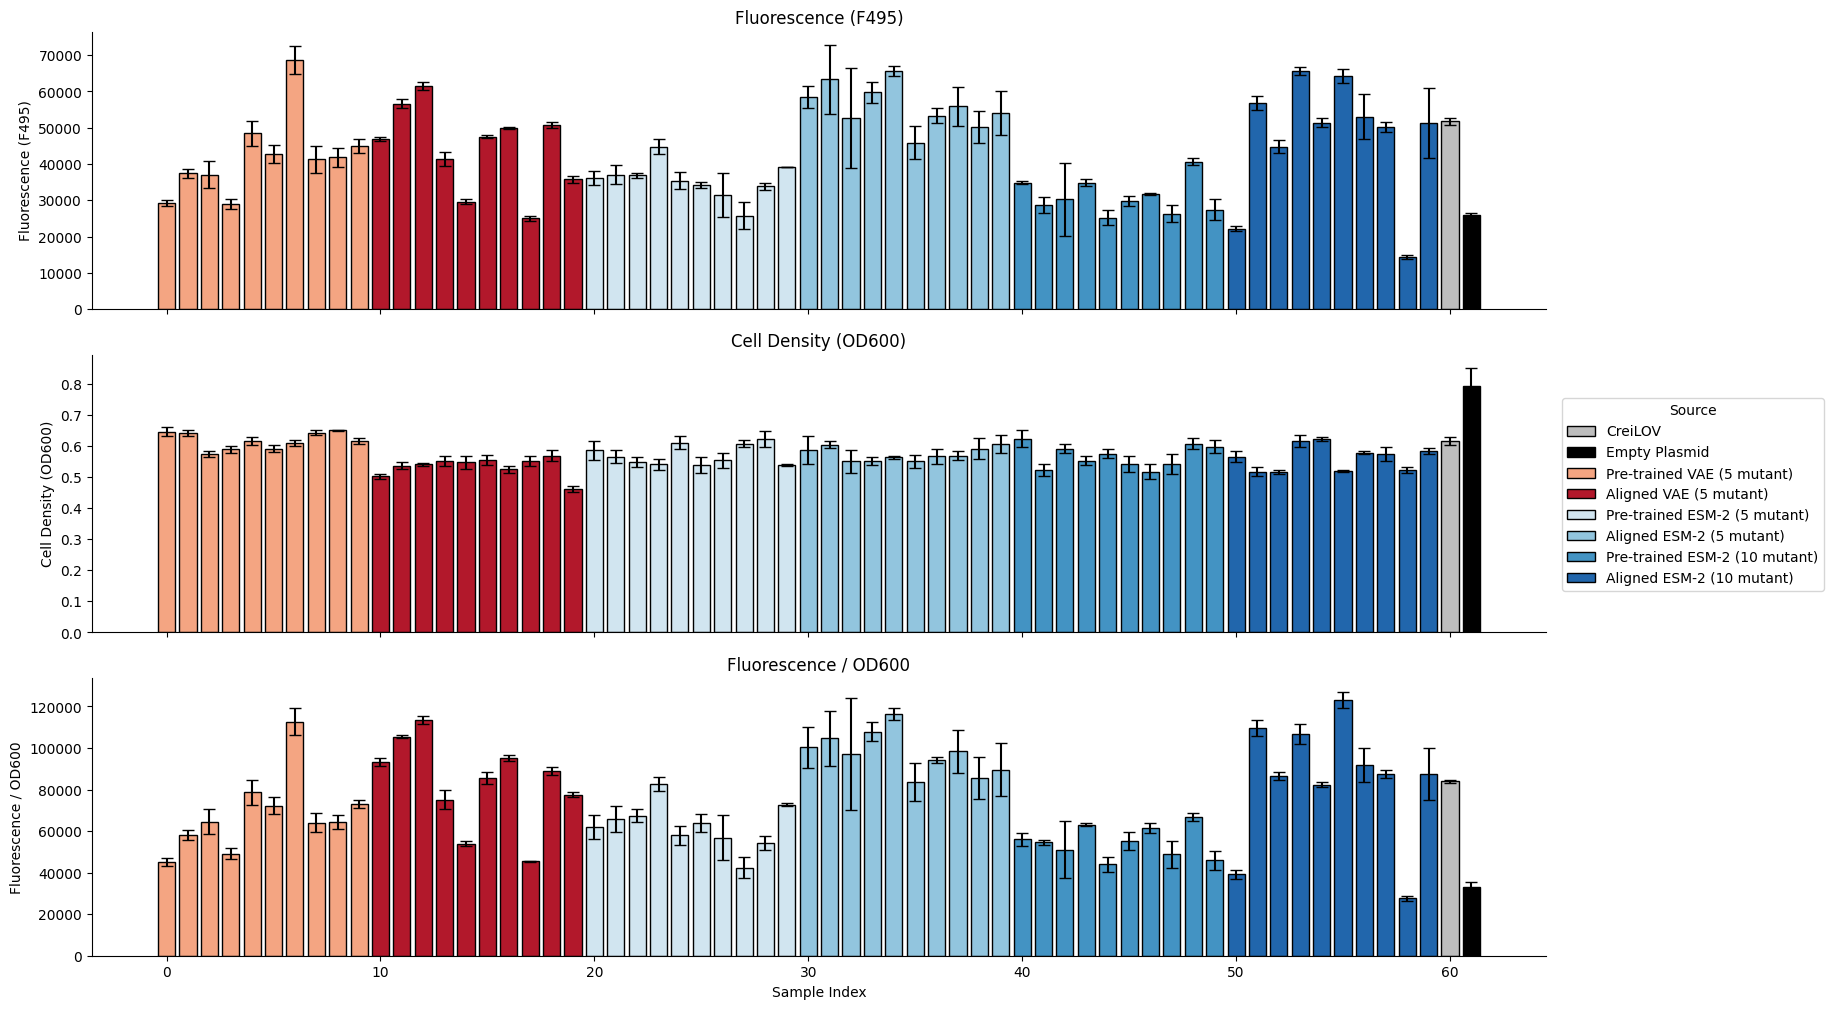

In [68]:
# Load the data
df = pd.read_csv("Data.csv")

# Set up figure with 3 bar plots (one per metric)
fig, axs = plt.subplots(3, 1, figsize=(18, 10), sharex=True)

# Define metric columns
plot_specs = [
    ('Avg F495', 'SD F495', 'Fluorescence (F495)'),
    ('Avg OD600', 'SD OD600', 'Cell Density (OD600)'),
    ('Avg F495/OD', 'SD F495/OD', 'Fluorescence / OD600')
]

# Color mapping based on Source value
color_map = {
    "CreiLOV": "#bdbdbd",
    "Empty Plasmid": "black",
    "Pre-trained VAE (5 mutant)": "#f4a582",
    "Aligned VAE (5 mutant)": "#b2182b",
    "Pre-trained ESM-2 (5 mutant)": "#d1e5f0",
    "Aligned ESM-2 (5 mutant)": "#92c5de",
    "Pre-trained ESM-2 (10 mutant)": "#4393c3",
    "Aligned ESM-2 (10 mutant)": "#2166ac"
}

def bar_color(source):
    return color_map.get(source, "#1f77b4")

colors = [bar_color(src) for src in df['Source']]

# Plot each bar chart
for ax, (mean_col, std_col, ylabel) in zip(axs, plot_specs):
    ax.bar(range(len(df)), df[mean_col], yerr=df[std_col], capsize=4, color=colors, edgecolor='k')
    ax.set_ylabel(ylabel)
    ax.set_title(ylabel)

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Add legend to the right of the figure (once, not repeated)
legend_elements = [Patch(facecolor=color, edgecolor='k', label=label) for label, color in color_map.items()]
fig.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.02, 0.5), title="Source")

# Adjust layout to leave space on the right
plt.tight_layout(rect=[0, 0, 0.87, 1])  # leave space for legend
axs[-1].set_xlabel("Sample Index")
plt.savefig("bar_charts_per_sample.png", dpi=300)
plt.savefig("bar_charts_per_sample.svg", dpi=300)
plt.show()
